## Exercise 11: Visual Odometry



Camera matrix:
[[3.117474e+03 0.000000e+00 1.501941e+03]
 [0.000000e+00 3.117474e+03 9.847680e+02]
 [0.000000e+00 0.000000e+00 1.000000e+00]]


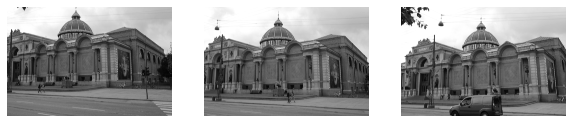

In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

#Load the camera matrix
K = np.loadtxt('Glyp/K.txt')
print('Camera matrix:')
print(np.round(K,3))

#We load the first three images:
im0 = plt.imread("Glyp/sequence/000001.png")
im1 = plt.imread("Glyp/sequence/000002.png")
im2 = plt.imread("Glyp/sequence/000003.png")


fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(10,7))
ax1.imshow(im0,cmap='gray')
ax1.axis('off')
ax2.imshow(im1,cmap='gray')
ax2.axis('off')
ax3.imshow(im2,cmap='gray')
ax3.axis('off')
plt.show()


- **Exercise 11.1**. Find SIFT keypoints `(kp0, kp1, kp2)` in all three images and compute their corresponding descriptors `(des0, des1, des2)`. For speed reasons, you can limit the number of SIFT features to 2000. Convert the features to numpy arrays of 2D points.


Match the SIFT features between im0 and im1 (matches01), and between im1 and im2 (matches12). Convert the matches to numpy arrays of the indices.



In [4]:
#The sift functions ONLY accepts images with 8 bit integer values.
im0_8 = cv2.normalize(im0, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
im1_8 = cv2.normalize(im1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
im2_8 = cv2.normalize(im2, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')


# Initiate SIFT detector
sift = cv2.SIFT_create(2000)


# find the keypoints and descriptors with SIFT
kp0, des0 = sift.detectAndCompute(im0_8,None)
kp1, des1 = sift.detectAndCompute(im1_8,None)
kp2, des2 = sift.detectAndCompute(im2_8,None)

#Convert the features to numpy arrays of 2D points
kp0_a = np.array([k.pt for k in kp0])
kp1_a = np.array([k.pt for k in kp1])
kp2_a = np.array([k.pt for k in kp2])

In [5]:
len(kp0_a), len(kp1_a),len(kp2_a)

(2000, 2000, 2000)

In [14]:
# BFMatcher with default params
bf = cv2.BFMatcher()

matches01 = bf.knnMatch(des0,des1,k=2)
matches12 = bf.knnMatch(des1,des2,k=2)

     
print('Number of matches 01:',len(matches01))
print('Number of matches 12:',len(matches12))

#Convert the matches to numpy arrays of the indices
matches01_a = np.array([(m.queryIdx, m.trainIdx) for m,n in matches01])
matches12_a = np.array([(m.queryIdx, m.trainIdx) for m,n in matches12])

print(matches01_a.shape)
print(matches12_a.shape)


matched_img = cv2.drawMatches(im0_8 , kp1, im1_8 , kp2,matches01_a, im1_8 ,flags=2)

plt.imshow(matched_img)
plt.axis('off')
plt.show()



Number of matches 01: 2000
Number of matches 12: 2000
(2000, 2)
(2000, 2)


error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'drawMatches'
> Overload resolution failed:
>  - Can't parse 'matches1to2'. Sequence item with index 0 has a wrong type
>  - Can't parse 'matches1to2'. Sequence item with index 0 has a wrong type
>  - drawMatches() missing required argument 'matchesThickness' (pos 7)
>  - drawMatches() missing required argument 'matchesThickness' (pos 7)


- **Exercise 11.2**. Estimate the essential matrix between `im0` and `im1` with RANSAC. You can use the OpenCV function `cv2.findEssentialMat` to do this.

Decompose the essential matrix and find the correct relative pose (R1, t1). For this we can again use an OpenCV function namely `cv2.recoverPose`.

The mask returned by `cv2.recoverPose` indicates which of the matches are inliers, that lie in front of both cameras. Remove the matches that are not inliers from matches01, so that only contains the inliers.


In [48]:
E,_=cv2.findEssentialMat(kp0_a,kp1_a, method=cv2.RANSAC)
print('Essential Matrix:')
print(E)
points,R1_esti,t1_esti, mask=cv2.recoverPose(E,kp0_a,kp1_a)
print('Estimate R1:')
print(R1_esti)
print('Estimate t1:')
print(t1_esti)

Essential Matrix:
[[-1.29319168e-04  1.17959547e-03 -7.03657801e-01]
 [-7.05246997e-04  2.47928067e-04 -6.97439863e-02]
 [ 6.94779779e-01 -1.31454907e-01 -4.17564062e-04]]
Estimate R1:
[[ 9.59439732e-01 -2.81913072e-01 -6.48919588e-04]
 [ 2.81913436e-01  9.59439681e-01  5.59953963e-04]
 [ 4.64740860e-04 -7.20181231e-04  9.99999633e-01]]
Estimate t1:
[[ 9.86335711e-02]
 [-9.95123327e-01]
 [-9.91756736e-04]]


In [87]:
m,n=np.where(mask==255)
matches_inliers= matches01_a[m,:]
print('Number of inliers matches:',len(matches_inliers))

Number of inliers matches: 1273


- **Exercise 11.3**. Use matches01 and matches12 and find the subset of matches such that we can match features all the way from image 0 to image 2. In other words, create three lists such that `points0[i]`, `points1[i]`, and `points2[i]` are the 2D locations of the same point in the corresponding images. For this you can use
`_, idx01, idx12 = np.intersect1d(matches01[:,1], matches12[:,0], return_indices=True)`


In [100]:
_, idx01, idx12 = np.intersect1d(matches01_a[:,1], matches12_a[:,0], return_indices=True)

In [137]:
intersect01=matches01_a[idx01]
intersect12=matches12_a[idx12]

print(len(intersect01))
print(len(intersect12))

points0=kp0_a[intersect01[:,0],:]
points1=kp1_a[intersect01[:,1],:]
points11=kp1_a[intersect12[:,0],:]
points2=kp2_a[intersect12[:,1],:]

#points1 and points11 are the same
#Proven by:
print(np.where((points11==points1)==False))

print(points0.shape)
print(points1.shape)
print(points2.shape)


1275
1275
(array([], dtype=int64), array([], dtype=int64))
(1275, 2)
(1275, 2)
(1275, 2)


- **Exercise 11.4**. For the points that have been tracked through all three images, use the 2D positions in image 0 and 1 to triangulate the points in 3D (Q). Using the 2D positions in image 2, estimate the pose of image 2 with RANSAC. Use `cv2.solvePnPRansac` to do this. As the lens distortion is already corrected, you can set `distCoeffs=np.zeros(5)`.


Visualize the 3D points that are also inliers for solvePnPRansac.

`fig = plt.figure()
ax = fig.add_subplot(projection=’3d’)
ax.scatter(*Q[inliers.flatten()]`

Also plot the position of the cameras. Recall that the position of the camera is not the translation. How do you find the position?

In [152]:
R0=np.eye(3)
t0=np.array([0,0,0])
Cam0=np.column_stack((R0,t0))
print(Cam0)
Cam1=np.column_stack((R1_esti,t1_esti))
print(Cam1)

#We need the projection matrix to triangulate the 2D points of image 0 and 1  to 3D. 

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
[[ 9.59439732e-01 -2.81913072e-01 -6.48919588e-04  9.86335711e-02]
 [ 2.81913436e-01  9.59439681e-01  5.59953963e-04 -9.95123327e-01]
 [ 4.64740860e-04 -7.20181231e-04  9.99999633e-01 -9.91756736e-04]]


In [215]:
def triangulate(Q0,Q1, proj_mat):
    x1=Q0[0]
    y1=Q0[1]
    
    x2=Q1[0]
    y2=Q1[1]
    
    B_i1=np.array([proj_mat[0][2][:-1]*x1 - proj_mat[0][0][:-1]],[proj_mat[0][2][:-1]*y1 - proj_mat[0][1][:-1]])
    B_i2=np.array([proj_mat[1][2][:-1]*x2 - proj_mat[1][0][:-1]],[proj_mat[1][2][:-1]*y2 - proj_mat[1][1][:-1]])

    #B=np.vstack([B_i1, B_i_2])
    
    return B_i1

In [216]:
proj_mat=[Cam0,Cam1]
for i in range(len(points0)):
    Q0=points0[i]
    Q1=points1[i]
    B=triangulate(Q0,Q1, proj_mat)


TypeError: Field elements must be 2- or 3-tuples, got 'array([  0.        ,  -1.        , 592.05584717])'

In [196]:
x=points0[0][0]
y=points0[0][1]
print(x)




157.91073608398438


(array([ -1.        ,   0.        , 157.91073608]),
 [array([  0.        ,  -1.        , 592.05584717])])

### Expand your algorithm

Now you will expand your algorithm so it can work for more than three images.

For this I suggest that you create lists of store the relevant objects for each frame `(Rs, ts, kps, etc.)`


- **Exercise 11.5**. Iterate through all images in the folder, repeating the steps in Exercises 11.3 and 11.4 for the previous three images each time.

Visualize all the 3D points and camera positions. Does it look correct?





In [170]:
for ind, a in enumerate(pixel_coord):
    print('index')
    for aa in a:
        print(aa)

index
[157.91073608 592.05584717]
[157.91073608 592.05584717]
[158.99226379 626.95758057]
[158.99226379 626.95758057]
[157.69656372 600.5345459 ]
[1117.50268555  675.60821533]
[157.69656372 600.5345459 ]
[168.50080872 609.15112305]
[2440.42822266 1489.14489746]
[1829.7376709   505.60333252]
[156.50793457 613.46112061]
[1637.47033691  558.27600098]
[184.63801575 583.12078857]
[3000.10571289  761.36260986]
[2338.34106445 1423.24731445]
[123.96245575 604.4140625 ]
[129.53936768 609.58532715]
[2440.47827148 1460.62072754]
[171.88101196 609.85479736]
[510.37353516 253.37582397]
[154.55271912 611.2109375 ]
[1210.25646973  660.06140137]
[151.92132568 434.22088623]
[2442.96459961 1483.78369141]
[2995.41381836  762.33251953]
[2999.24584961  773.24609375]
[1129.81555176  674.1003418 ]
[2440.47827148 1460.62072754]
[163.49771118 596.0602417 ]
[130.0609436  616.73028564]
[1172.61108398  639.80535889]
[819.1472168  702.58239746]
[2337.48779297 1448.22717285]
[2973.16333008  761.51367188]
[491.80130

[1629.96386719 1499.66955566]
[1621.22973633 1500.30053711]
[1621.22973633 1500.30053711]
[247.09295654 734.08947754]
[ 245.87452698 1435.40380859]
[2714.46630859 1630.35205078]
[245.6290741  310.63580322]
[368.88098145 592.78271484]
[1078.03393555  725.7142334 ]
[1078.23486328  718.69061279]
[1078.50878906  708.34887695]
[2705.58984375  673.80670166]
[245.32887268 267.45089722]
[245.02481079 263.7026062 ]
[368.88098145 592.78271484]
[2702.07226562 1625.24633789]
[1080.75830078  738.00317383]
[1598.60803223  520.85632324]
[243.88829041 713.95587158]
[1598.60803223  520.85632324]
[243.51080322 736.46899414]
[1081.10351562  662.47381592]
[1081.10351562  662.47381592]
[242.95179749 725.05554199]
[241.56832886 313.42337036]
[241.56832886 313.42337036]
[241.19064331 259.62948608]
[1083.01196289  671.34289551]
[1085.15979004  587.15783691]
[2977.36889648  954.45910645]
[239.00054932 361.86010742]
[238.41465759 366.03305054]
[2805.01904297 1640.07641602]
[238.41465759 366.03305054]
[1087.6745

[1072.98083496  772.3394165 ]
[1516.92443848  434.70959473]
[2494.94946289 1361.59375   ]
[1438.02294922  391.0491333 ]
[ 246.50071716 1444.8885498 ]
[174.61714172 642.96899414]
[ 294.76809692 1078.07019043]
[1286.77197266  691.06243896]
[2475.82763672 1556.0032959 ]
[ 245.26148987 1480.43029785]
[1599.2857666   517.00665283]
[ 541.58099365 1415.85546875]
[2475.82763672 1556.0032959 ]
[1459.08544922  417.2322998 ]
[2271.50268555 1055.88098145]
[2271.50268555 1055.88098145]
[967.76611328 890.53729248]
[ 375.06109619 1420.78735352]
[376.25317383 611.76226807]
[1169.37353516  693.51275635]
[1820.54406738  723.13085938]
[1945.29858398  740.95440674]
[1278.59484863  592.55102539]
[2483.04174805  741.36938477]
[341.32553101 759.69250488]
[1525.11242676  459.34393311]
[1399.69628906  497.22616577]
[787.41217041 701.03216553]
[ 563.09008789 1526.57312012]
[1237.56872559  426.45910645]
[658.72039795 652.13800049]
[342.802948   625.34545898]
[1143.57336426  575.03424072]
[299.16381836 988.866455

array([0, 0, 0])